# Generative Question Answering in low performance environments

# Introduction

During the NLP course we had to produce, unsing the Hugging Face transformers library, a simple Open Generative Question Answering (QA) model. The task was also constraint in using a specific transformer-based model, limiting the possible approaches. At the end, general results were not great, leading me in wanting to try different approaches to better understand this complex and still less explored subject.

## Subject of analysis

As stated before, here we are going to analyze the Question Answering task, trying to produce a model which can retrieve the answer from a given question and its context.

More precisely, the [main variants](https://huggingface.co/tasks/question-answering) of this task are:

- **Extractive QA**: 

    The model extracts the answer from a context. The context is provided as text passage. This is usually solved with BERT-like models.  

- **Open Generative QA**: 

    The model generates free text directly based on the context.

- **Closed Generative QA**: 

    In this case, no context is provided. The answer is completely generated by a model.

The main objective of this notebook is to explore Open Generative QA and understand how can it be improved in simple and limited developing environment such as Colab.

## Generative QA

Answering questions in natural language can be beneficial to a variety of QA applications, and has led to the development of smart devices such as Siri, Cortana and Alexa. However, compared to answer extraction, answer generation for reading comprehension is more challenging, and has been less explored.

As stated in the [Li et al.](https://aclanthology.org/2021.acl-short.118/) paper, although much work has been done in neural language generation for summarization, out-of-control generation still has its problems, such as the "Semantic drift" of the answer from the passage (the answer has little or no semantic affiliation with the question).


In the first part of the notebook we are going to analyze one of the most performing model in generative QA, while in the second half we are going to analyze if an ensamble of specific models could preform better in this low resources envirnoments.

## Model structure

We are going to experiment with transformer-based models to define a final architecture of the form:

A = f_θ(Q,P)

where:
- f is the transformer-based model we have to define.
- θ parameters.
- Q question
- P Passage or context of the question
- A the generated answer

# Initial Setup

## Imports

In [ ]:
!pip install transformers --upgrade
!pip install datasets
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 23.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 kB 16.5 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.10.1
    Uninstalling huggingface-hub-0.10.1:
      Successfully uninstalled huggingface-hub-0.10.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.20.1
    Uninstalling transformers-4.20.1:
      Successfully uninstalled transformers-4.20.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cached-path 1.1.6 requires huggingface-hub<0.11.0,>=0.8.1, but you have huggingface-hub 0.12.0 which is incompatible.
allennlp 2.10.1 requires transformers<4.21,>=4.1, but you have transformers 4.26.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 1.

In [ ]:
# File and download imports
import os
import urllib.request
import json
from tqdm import tqdm

# Dataframe management
import pandas as pd 

# Data manipulation
import numpy as np  
import random

# Classification with sklearn
from sklearn import metrics
from sklearn.utils import resample
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import ComplementNB, MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

# Convert to HuggingFace dataset
import pyarrow as pa
import datasets

# Transformers
import transformers
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, TFT5ForConditionalGeneration, TFAutoModelForQuestionAnswering, AdamWeightDecay, DataCollatorForSeq2Seq

# Evaluation
from evaluate import load

# Tensorflow
import tensorflow as tf

## Download the [CoQA](https://stanfordnlp.github.io/coqa/) dataset

Also the [SQuAD](https://rajpurkar.github.io/SQuAD-explorer/) could have been utilized but CoQA was ultimately chones due to:

- Its complexity due to the presence of interconnected questions
- It was the same dataset used in the NLP course assignment, creating a good comparison

In [ ]:
class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)
        
def download_url(url, output_path):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=output_path, reporthook=t.update_to)

def download_data(data_path, url_path, suffix):    
    if not os.path.exists(data_path):
        os.makedirs(data_path)
        
    data_path = os.path.join(data_path, f'{suffix}.json')

    if not os.path.exists(data_path):
        print(f"Downloading CoQA {suffix} data split... (it may take a while)")
        download_url(url=url_path, output_path=data_path)
        print("Download completed!")

In [ ]:
data_path='coqa'

# Train data
train_url = "https://nlp.stanford.edu/data/coqa/coqa-train-v1.0.json"
download_data(data_path=data_path, url_path=train_url, suffix='train')

# Test data
test_url = "https://nlp.stanford.edu/data/coqa/coqa-dev-v1.0.json"
download_data(data_path=data_path, url_path=test_url, suffix='test')  # <-- Why test? See next slides for an answer!

coqa-train-v1.0.json: 49.0MB [00:05, 8.91MB/s]                            


Download completed!


coqa-dev-v1.0.json: 9.09MB [00:01, 9.09MB/s]                            

Download completed!


# Data Inspection

## Dataset Statistics

* **127k** QA pairs.
* **8k** conversations.
* **7** diverse domains: Children's Stories, Literature, Mid/High School Exams, News, Wikipedia, Reddit, Science.
* Average conversation length: **15 turns** (i.e., QA pairs).
* Almost **half** of CoQA questions refer back to **conversational history**.
* Only **train** and **validation** sets are available.

## Dataset snippet

The dataset is stored in JSON format. Each dialogue is represented as follows:

```
{
    "source": "mctest",
    "id": "3dr23u6we5exclen4th8uq9rb42tel",
    "filename": "mc160.test.41",
    "story": "Once upon a time, in a barn near a farm house, there lived a little white kitten named Cotton. 
    Cotton lived high up in a nice warm place above the barn where all of the farmer's horses slept. [...]" % <-- $P$
    "questions": [
        {
            "input_text": "What color was Cotton?",   % <-- $Q_1$
            "turn_id": 1
        },
        {
            "input_text": "Where did she live?",  % <-- $Q_2$
            "turn_id": 2
        },
        [...]
    ],
    "answers": [
        {
            "span_start": 59,   % <-- $R_1$ start index
            "spand_end": 93,    % <-- $R_1$ end index
            "span_text": "a little white kitten named Cotton",   % <-- $R_1$
            "input_text" "white",   % <-- $A_1$      
            "turn_id": 1
        },
        [...]
    ]
}
```

For each source we have multiples stories and, for each one of them, multiple QAs.

Each answer will include:

- The span of the answer
- The text of the answer
- Its id

Each dialogue also contains an additional field ```additional_answers```. For simplicity, we are going to **ignore** this field, taking only the original answer.

Furthermore, CoQA contains 1.3% of unanswerable questions. For simplicity, we **ignore** those QA pairs.

## Dataframe manipulation

In [ ]:
# Random seed function
def set_random_seeds(seed: int):
  # Sets the random seed for reproducibility
  os.environ['PYTHONHASHSEED']=str(seed)
  os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # new flag present in tf 2.0+
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)

In [ ]:
# To better handle huggingface transformers, we convert our dataframes to a dict of hg datasets
def convert_to_hg_dataset(coulmns_to_remove, train, val):
    hg_train = datasets.Dataset(pa.Table.from_pandas(train.drop(coulmns_to_remove, axis=1)))
    hg_val = datasets.Dataset(pa.Table.from_pandas(val.drop(coulmns_to_remove, axis=1)))

    hg_ds = datasets.DatasetDict({"train":hg_train,"val":hg_val})

    return hg_ds

In [ ]:
def json_to_pandas(file_name):
  """
    Given the name of the json file downloaded from CoQA, tranform its data
    into a pandas dataframes

    Param:
        - file_name: name of the json file to transform

    Return:
        - df_qa: dataframe containing all the stories, questions, R1s and answers
    """

  # Get the json fie
  file_path = data_path+'/'+file_name
  json_file = open(file_path).read()
  json_dict = json.loads(json_file)

  # Part of the dict with our data
  json_data = json_dict['data']

  # Len of our list of dict
  l = sum(1 for a in json_data)

  question_answer = []

  # Loop into the json dict
  for i in range(l):

    # Len of question/answer
    l_qa = sum(1 for a in json_data[i]['questions'])

    # Iterate on question/answer for the current story
    for j in range(l_qa):
      qa = {}
      qa['story_id'] = i
      qa['story'] = json_data[i]['story']
      qa['question'] = json_data[i]['questions'][j]['input_text']
      qa['answer'] = json_data[i]['answers'][j]['input_text']
      qa['R1_start'] = json_data[i]['answers'][j]['span_start']
      qa['R1_end'] = json_data[i]['answers'][j]['span_end']
      qa['R1'] = json_data[i]['answers'][j]['span_text']
      question_answer.append(qa)

  # Create dataframe
  df_qa = pd.DataFrame(question_answer)

  # Remove unkown answers
  # Questions wthout answers have: answer = unkown, R1_start = -1. R1_end = -1, R1 = unkown
  df_qa = df_qa[df_qa.R1_start != -1]

  return df_qa

Since CoQA only provides train and test datasets, we need to produce the validation dataset.

We decided to perform the split in the training set such that:

- The split can be freely chosen, in our case we utilized a 80-20 split.
- The splits must be performed such that a dialogue appears in one split only (i.e., split at dialogue level)

In [ ]:
# Reproducibility
random.seed(42)

# Split function
def train_val_split(dataframe, split, rand):
  """
    Perform train/val split based on the stories, correctly having all the 
    question of a given story in the same split

    Param:
        - datafram: dataframe to perform the split
        - split: percentage of the split (IN DECIMAL FORMAT)
        - rand: True for random split, False simple sequential split

    Return:
        - df_train: train dataframe
        - df_val: validation dataframe
    """

  # Input mishandling
  if not isinstance(rand, (bool)):
    raise ValueError("Rand must be a boolean value")

  if not 0 <= split <= 1:
    raise ValueError("Split must be between 0.0 and 1.0")


  # Get total number of stories
  number_of_stories = dataframe['story_id'].iloc[-1]

  # Randomly choose stories
  split_id = int(number_of_stories*split)

  if rand == True:
    split_list = random.sample(range(0, number_of_stories), split_id)
  else:
    split_list = [*range(0, split_id)]

  # Create train and val dataframes
  df_train = dataframe[dataframe['story_id'].isin(split_list)]
  df_val = dataframe[dataframe["story_id"].isin(split_list) == False]

  return df_train.reset_index().drop('index', axis = 1), df_val.reset_index().drop('index', axis = 1)

We decided to introduce in our dataframes one additional column `y` which defines if a question is an open question (0) or a yes-or-no question (1).

This additional classification will be later explained in the ensamble part.

In [ ]:
# Train
df_train_qa = json_to_pandas('train.json')

# Take the answers
df_answers = df_train_qa['answer'].copy()

# Set the answers to lowercase to better manipulate them
df_train_qa['answer'] = df_train_qa['answer'].apply(str.lower)

# Insert a new column
df_train_qa['y'] = df_train_qa.apply(lambda x: 1 if((x['answer'] == 'yes' or x['answer'] == 'yes.') or (x['answer'] == 'no' or x['answer'] == 'no.')) else 0, axis=1)

# Reset the answers in the original format
df_train_qa = df_train_qa.drop(['answer'], axis = 1)
df_train_qa = df_train_qa.join(df_answers)


# Test
df_test_qa = json_to_pandas('test.json')

# Take the answers
df_answers = df_test_qa['answer'].copy()

# Set the answers to lowercase to better manipulate them
df_test_qa['answer'] = df_test_qa['answer'].apply(str.lower)

# Insert a new column
df_test_qa['y'] = df_test_qa.apply(lambda x: 1 if((x['answer'] == 'yes' or x['answer'] == 'yes.') or (x['answer'] == 'no' or x['answer'] == 'no.')) else 0, axis=1)

# Reset the answers in the original format
df_test_qa = df_test_qa.drop(['answer'], axis = 1)
df_test_qa = df_test_qa.join(df_answers)

Now that we have correctly created our train and test dataframes, we can inspect its data.

In [ ]:
df_test_qa

,story_id,story,question,R1_start,R1_end,R1,y,answer
0,0,"Once upon a time, in a barn near a farm house,...",What color was Cotton?,59,93,a little white kitten named Cotton,0,white
1,0,"Once upon a time, in a barn near a farm house,...",Where did she live?,18,80,"in a barn near a farm house, there lived a lit...",0,in a barn
2,0,"Once upon a time, in a barn near a farm house,...",Did she live alone?,196,215,Cotton wasn't alone,1,no
3,0,"Once upon a time, in a barn near a farm house,...",Who did she live with?,281,315,with her mommy and 5 other sisters,0,with her mommy and 5 sisters
4,0,"Once upon a time, in a barn near a farm house,...",What color were her sisters?,428,490,her sisters were all orange with beautiful whi...,0,orange and white
...,...,...,...,...,...,...,...,...
7978,499,"Las Vegas (, Spanish for ""The Meadows""), offic...","where does the nickname ""Sin City"" come from?",1037,1131,The city's tolerance for numerous forms of adu...,0,The city's tolerance for numerous forms of adu...
7979,499,"Las Vegas (, Spanish for ""The Meadows""), offic...",Which state is it in?,100,207,"Vegas, is the 28th-most populated city in the ...",0,Nevada
7980,499,"Las Vegas (, Spanish for ""The Meadows""), offic...",Is it located in a desert?,326,358,within the greater Mojave Desert,1,Yes
7981,499,"Las Vegas (, Spanish for ""The Meadows""), offic...",what is the name of the desert?,345,359,Mojave Desert.,0,Mojave Desert.


In [ ]:
df_train_qa

,story_id,story,question,R1_start,R1_end,R1,y,answer
0,0,"The Vatican Apostolic Library (), more commonl...",When was the Vat formally opened?,151,179,Formally established in 1475,0,It was formally established in 1475
1,0,"The Vatican Apostolic Library (), more commonl...",what is the library for?,454,494,he Vatican Library is a research library,0,research
2,0,"The Vatican Apostolic Library (), more commonl...",for what subjects?,457,511,Vatican Library is a research library for hist...,0,"history, and law"
3,0,"The Vatican Apostolic Library (), more commonl...",and?,457,545,Vatican Library is a research library for hist...,0,"philosophy, science and theology"
4,0,"The Vatican Apostolic Library (), more commonl...",what was started in 2014?,769,879,"March 2014, the Vatican Library began an initi...",0,a project
...,...,...,...,...,...,...,...,...
108642,7198,(CNN) -- Cristiano Ronaldo provided the perfec...,Who was a sub?,1405,1427,substitute Xabi Alonso,0,Xabi Alonso
108643,7198,(CNN) -- Cristiano Ronaldo provided the perfec...,Was it his first game this year?,1415,1467,Xabi Alonso made his first appearance of the ...,1,Yes
108644,7198,(CNN) -- Cristiano Ronaldo provided the perfec...,What position did the team reach?,1520,1555,Real moved up to third in the table,0,third
108645,7198,(CNN) -- Cristiano Ronaldo provided the perfec...,Who was ahead of them?,1557,1582,six points behind Barca.,0,Barca.


In [ ]:
print("Train Dataset\n\n---\n")
print("Dataset size: \t\t\t", df_train_qa.shape)
print("\nDataset columns: \t\t", df_train_qa.columns.values) 

Train Dataset

---

Dataset size: 			 (107286, 8)

Dataset columns: 		 ['story_id' 'story' 'question' 'R1_start' 'R1_end' 'R1' 'y' 'answer']


In [ ]:
df_train_qa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107286 entries, 0 to 108646
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   story_id  107286 non-null  int64 
 1   story     107286 non-null  object
 2   question  107286 non-null  object
 3   R1_start  107286 non-null  int64 
 4   R1_end    107286 non-null  int64 
 5   R1        107286 non-null  object
 6   y         107286 non-null  int64 
 7   answer    107286 non-null  object
dtypes: int64(4), object(4)
memory usage: 11.4+ MB


In [ ]:
df_train_qa.describe()

,story_id,R1_start,R1_end,y
count,107286.000000,107286.000000,107286.000000,107286.000000
mean,3615.448726,661.783336,715.118468,0.195021
std,2080.487032,486.726486,490.785795,0.396219
min,0.000000,0.000000,3.000000,0.000000
25%,1808.250000,246.000000,297.000000,0.000000
50%,3622.000000,596.000000,650.000000,0.000000
75%,5423.000000,1012.000000,1069.000000,0.000000
max,7198.000000,6065.000000,6077.000000,1.000000


Total number of questions: 	 107286
Number of yes-or-no questions: 	 20923 ( 19.50 % )
Number of open questions: 	 86363 ( 80.50 % )




<AxesSubplot:ylabel='Type'>

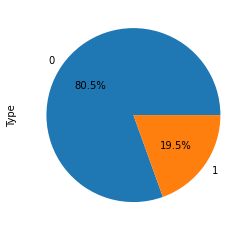

In [ ]:
num_yesno = df_train_qa[df_train_qa['y'] == 1].shape[0]
num_open = df_train_qa[df_train_qa['y'] == 0].shape[0]
num_questions = df_train_qa.shape[0]

print("Total number of questions: \t", num_questions)
print("Number of yes-or-no questions: \t", num_yesno, "(", "{:.2f}".format((num_yesno*100)/num_questions), "% )")
print("Number of open questions: \t", num_open, "(", "{:.2f}".format((num_open*100)/num_questions), "% )\n\n")

df_train_qa.groupby('y').size().plot(kind='pie',
                                       y = "y",
                                       label = "Type",
                                       autopct='%1.1f%%')

We can see that our data is quite **imbalance**.

As a rule of thumb, if a two-class dataset has a difference of greater than 65% to 35%, than it should be looked at as a dataset with class imbalance ([Machine Learning: How to Handle Class Imbalance](https://medium.com/analytics-vidhya/machine-learning-how-to-handle-class-imbalance-920e48c3e970)).

Possible apprach:

- Up-sample Minority Class (safer, but increase computational costs).

- Down-sample Majority Class (quicker but we may loose information).

At the moment, we will not perform any data manipulation to our dataframes.

# Reference Model: T5

As our first approach, we will utilize the [T5](https://arxiv.org/pdf/1910.10683.pdf) model to perform generative QA.

T5 exploits the power of transfer learning (pre-train a model on a data-rich task before being fine-tuned on a downstream task) reaching, as the paper states, *state-of-the-art results on many benchmarks covering summarization, question answering, text classification, and more.*

[Natural Language Inference](https://paperswithcode.com/sota/natural-language-inference-on-rte) latest performance.

T5 is an encoder-decoder model pre-trained on a multi-task mixture of unsupervised and supervised tasks and for which each task is converted into a text-to-text format.

Being a Text Generation model (also known as causal language model), it is particularly suited for our answer generation problem. More precisely, these models are trained to learn the mapping between a pair of texts, in our case questions and answers.

Due to the limitation of our environment, we are going to take a subset of stories to perform training and validation.

In [ ]:
# Take a reduced portion of the dataframed to reuce computational costs
df_reduced_t5 = df_train_qa[df_train_qa['story_id'] <= 5000].copy()

# Perform the split
df_train_t5, df_val_t5 = train_val_split(df_reduced_t5, 0.8, True)

In [ ]:
# Quick check for intersection
intersection = pd.merge(df_train_t5, df_val_t5, how='inner', on=['story_id'])
intersection.shape[0]

0

In [ ]:
hg_ds_t5 = convert_to_hg_dataset(['story_id', 'R1', 'R1_start', 'R1_end'], df_train_t5, df_val_t5)

We decided to use [T5-small](https://huggingface.co/t5-small) which is a checkpoint of T5 with 60 million parameters. This was chosen in order to reduce space occupance and improving computational speed at the cost of a slightly worse performance. 

In [ ]:
model_checkpoint_t5 = "t5-small"

We now have to import the:

- Tokenizer, to correctly perform preprocessing of our inputs.
- The model checkpoint.

    The specific model checkpoint chosen was `TFT5ForConditionalGeneration` which is a T5 Model with a language modeling head on top (to predict what the next token is).



In [ ]:
tokenizer_t5 = AutoTokenizer.from_pretrained(model_checkpoint_t5)
model_t5 = TFT5ForConditionalGeneration.from_pretrained(model_checkpoint_t5)

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at t5-small.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


### Preprocessing

To utilize the model, we first need to correctly preprocess our input sentences and convert them in a format the model expects, as well as generate the other inputs that the model requires.

Mainly, the [tokenizer](https://huggingface.co/docs/transformers/main_classes/tokenizer) performs:

- Tokenizing (splitting strings in sub-word token strings), converting tokens strings to ids and back, and encoding/decoding (i.e., tokenizing and converting to integers).

- Adding new tokens to the vocabulary.

- Managing special tokens (like mask, beginning-of-sentence, etc.): adding them, assigning them to attributes in the tokenizer for easy access and making sure they are not split during tokenization.

We also need to correctly format our text to the format in which our model was trained in order to maximize performance.

As stated in the original T5 paper, since we are dealing with a QA task, we need to give to the model an input formatted as:

- For the context-question part

    question: TEXT context: TEXT\</s>
    
- For the answer part

    TEXT \</s>
    

In [ ]:
max_target_length = 128

def preprocess_function_t5(examples):
    # Correctly format the inputs
    inputs = 'question: %s  context: %s' % (examples['question'], examples['story'])
    model_inputs = tokenizer_t5(inputs, truncation=False)

    # Setup the tokenizer for our "target", our answers
    with tokenizer_t5.as_target_tokenizer():
        labels = tokenizer_t5(
            examples["answer"], max_length=max_target_length, truncation=False
        )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:
tokenized_datasets_t5 = hg_ds_t5.map(preprocess_function_t5, remove_columns=hg_ds_t5["train"].column_names)

  0%|          | 0/59085 [00:00<?, ?ex/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (517 > 512). Running this sequence through the model will result in indexing errors


  0%|          | 0/15007 [00:00<?, ?ex/s]

In [ ]:
tokenized_datasets_t5

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 59085
    })
    val: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 15007
    })
})

The resulting dataset dictionary contains the:

- Training dataset.
- Validation dataset.

Both of them have:

- `input_ids` → Encoded input sentence.
- `attention_mask` → Indicates to the model which tokens should be attended to, and which should not (indicates the position of the padded indices).
- `labels` → Are the input_ids of the encoded target sequence.

The model will automatically create the `decoder_input_ids` based on the `labels`.

The padding will be later dealt with using a specific data collator.

In [ ]:
print(tokenizer_t5.decode(tokenized_datasets_t5["train"]['input_ids'][42]))
print("\n\n",tokenizer_t5.decode(tokenized_datasets_t5["train"]['labels'][42]))

print("\n\n",tokenized_datasets_t5["train"]['input_ids'][42])
print("\n\n",tokenized_datasets_t5["train"]['labels'][42])

question: How much did they originally cost to produce? context: (CNN) -- The longest-running holiday special still has a very shiny nose. "Rudolph the Red-Nosed Reindeer" premiered on television December 6, 1964, and is now one of the holiday season's perennial favorites. The story of the reindeer who saves Christmas is beloved among children and adults alike. The Rankin-Bass animated film production company used Japanese puppets and stop motion to tell the tale, bolstered by a soundtrack featuring Burl Ives' rendition of the theme song. In the story, Santa's reindeer Donner and his wife have a son, Rudolph, who has the distinction of a nose that glows. He runs away after being made to feel an outcast and links up with an elf who dreams of becoming a dentist and an adventurer seeking silver and gold. After ending up on the Island of Misfit Toys and wandering for a while, Rudolph goes on to save his loved ones from the Abominable Snow Monster and guides Santa through a blizzard that th

### Fine-tuning the model

In [ ]:
# Training hyperparameters

# Set random seed
seed = 42
set_random_seeds(seed=seed)

# Hyperparams
learning_rate = 1e-4 #1e-4
num_train_epochs = 1
weight_decay = 0.01
batch_size = 8

optimizer = AdamWeightDecay(learning_rate = learning_rate,
                            weight_decay_rate = weight_decay,)

Now we will use a data collator.

[Data collator](https://huggingface.co/docs/transformers/main_classes/data_collator) are objects that will form a batch and perform padding if needed, by using a list of dataset elements as input.

We utilized `DataCollatorForSeq2Seq` since is the one needed for our task (sequence-to-sequence (seq2seq) = Models that generate a new sequence from an input)

In [ ]:
data_collator = DataCollatorForSeq2Seq(tokenizer_t5, model=model_t5, return_tensors="np")

Next, we convert our datasets to `tf.data.Dataset`, which Keras understands natively. 

There are two ways to do this: we can use the slightly more low-level [`Dataset.to_tf_dataset()`](https://huggingface.co/docs/datasets/package_reference/main_classes#datasets.Dataset.to_tf_dataset) method, or we can use [`Model.prepare_tf_dataset()`](https://huggingface.co/docs/transformers/main_classes/model#transformers.TFPreTrainedModel.prepare_tf_dataset).

The main difference between these two is that the `Model` method can inspect the model to determine which column names it can use as input, which means you don't need to specify them yourself. 

In [ ]:
train_set_t5 = model_t5.prepare_tf_dataset(
    tokenized_datasets_t5["train"],
    batch_size=batch_size,
    shuffle=True,
    collate_fn=data_collator,
)

val_set_t5 = model_t5.prepare_tf_dataset(
    tokenized_datasets_t5["val"],
    batch_size=batch_size,
    shuffle=False,
    collate_fn=data_collator,
)

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Now we can complie the model by just specifing the optimizer.

The loss is automatically computed internally.

In [ ]:
# Compile the model
model_t5.compile(optimizer=optimizer)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


In [ ]:
# Train the model
model_t5.fit(
    x=train_set_t5,
    validation_data=val_set_t5,
    epochs=num_train_epochs
)

7385/7385 [==============================] - 2751s 370ms/step - loss: 1.2773 - val_loss: 1.0988


It was also tried to take a larger subset of our training dataset but, probably due to the size increase, the envirnoment ran out of memory.

### Inference

Let's see an example of answer.

In [ ]:
idx = 42

# inputs = tokenizer([question], [context], return_tensors="np")
input_text =  f"question: {df_val_t5['question'][idx]} context: {df_val_t5['story'][idx]}"
input_tokenized = tokenizer_t5(input_text, return_tensors='np', truncation=False)

# input_tokenized = tokenizer(input_text, return_tensors="np")
input_ids = input_tokenized.input_ids
attention_mask = input_tokenized.attention_mask

# Generate the answer
model_answer = model_t5.generate(input_ids)

print("Story: \n\n", df_val_t5['story'][idx], "\n\n")
print("\nQuestion: ", df_val_t5['question'][idx])
print("\n\nModel answer:  \t",tokenizer_t5.decode(model_answer[0], skip_special_tokens=True))
print("\nReal answer: \t",df_val_t5['answer'][idx])

Story: 

 Local businessmen are increasingly facing competition from online retailers. Larry Pollock, owner of Camera Co/Op on South Congress, said he has been dealing with this kind of problem for years, even before the Internet. The struggle began with mail-order catalogues , which are similar to online retailers in that they have few employees to pay, no sales tax fees and no business venue to lease and manage. 

"Their overhead is lower, but they don't offer a service like we do," Pollock said. 

Pollock, however, said providing a valuable service to customers does not always guarantee continued sales. 

"We spend 30 minutes to an hour with somebody and they go home and buy it on line," he said. 

According to the state comptroller's office, online shopping is developing at a more rapid rate than traditional businesses. 

In spite of how fair or unfair online shopping may be to the local businessmen, consumers will continue to turn to the Internet for its variety and accessibility,

To evaluate the actual performances of our model, we will use the [SQuAD metric](https://huggingface.co/spaces/evaluate-metric/squad).


There are two dominant metrics used by many question answering datasets, including SQuAD: exact match (EM) and F1 score. These scores are computed on individual question+answer pairs.

In [ ]:
squad_metric = load("squad")

# Take a randome slice of our test set
n_samples = 1000
test_eval_subset = df_test_qa.sample(n = n_samples, random_state = seed).reset_index()
f1s = []
ems = []

for idx in tqdm(range(n_samples)):
      
    input_text =  f"question: {test_eval_subset['question'][idx]} context: {test_eval_subset['story'][idx]}"
    inputs = tokenizer_t5(input_text, return_tensors='np', pad_to_max_length=True, truncation=True, max_length=1024)
    input_ids = inputs.input_ids

    outputs = model_t5.generate(input_ids)

    ref_text = test_eval_subset['answer'][idx]
    ref_start = test_eval_subset['R1_start'][idx]

    # Extract this substring from the inputs
    answer = tokenizer_t5.decode(outputs[0], skip_special_tokens=True)
    
    predictions = [{'prediction_text': answer, 'id': '1'}]
    references = [{'answers': {'answer_start': [ref_start], 'text': [ref_text]}, 'id': '1'}]
    results = squad_metric.compute(predictions=predictions, references=references)
    f1s.append(results['f1'])
    ems.append(results['exact_match'])

print("\n\nmean F1: ", np.mean(f1s))
print("\n\nmean EM: ", np.mean(ems))

100%|██████████| 1000/1000 [07:13<00:00,  2.31it/s]



mean F1:  54.72581772847185


mean EM:  43.9


# Ensamble approach

The main idea behind this approach was: "Since generative QA is still a complex and training demanding task, what if we decomposed the problem into smaller tasks which can be managed by more specialized models".

At the moment we know we have to operate with:

- A text passage which contains the information we want to extract to answer a question
- A list of questions and relative answers:
    - Yes-or-no questions
    - Open questions

From this base, the chosen approach follows two path:

1. Open question answering

    An already established approach in QA is the [Extractive QA](https://www.pinecone.io/learn/question-answering/) which consists in teaching the model to find the span in the passage where the answer lies.
    
    Due to its widely use in QA, this represented a good starting point, but still it could be improved.
    
    Since Extractive QA can only extract span of text from the passage which include the answer, finding the context for yes-or-no questions proved to be a difficult task for the model and, since at the end we want to provide a sort of generative answer, we decided to let the extractive QA model only train on open questions.
    
    Having now, in theory, the correct span where the answer lies, we can provide these outputs as input into a similar T5 generative model as before.
    
    We will have to fine tune a new text-to-text T5 model, always for QA (since it performed the best), but now with a simpler task: paraphrasing a span, given its question, in order to generate an answer.
    
    The new T5 model will work as a mixture of summarization and paraphrasing, having the advantage of dealing with a smaller input text with respect to the previous T5 model.
    
2. Yes-or-No question answering

    Having correctly defined a method to understand if a question is a yes-or-no QA (for instance using a Machine Learning approach), now we have to correctly address the [Boolean QA](https://arxiv.org/pdf/1905.10044.pdf) problem.
    
    This problem can be dealt as a classification task, teaching the model to classify an input as No (0) or Yes (1). The input will have the question and the relative context.

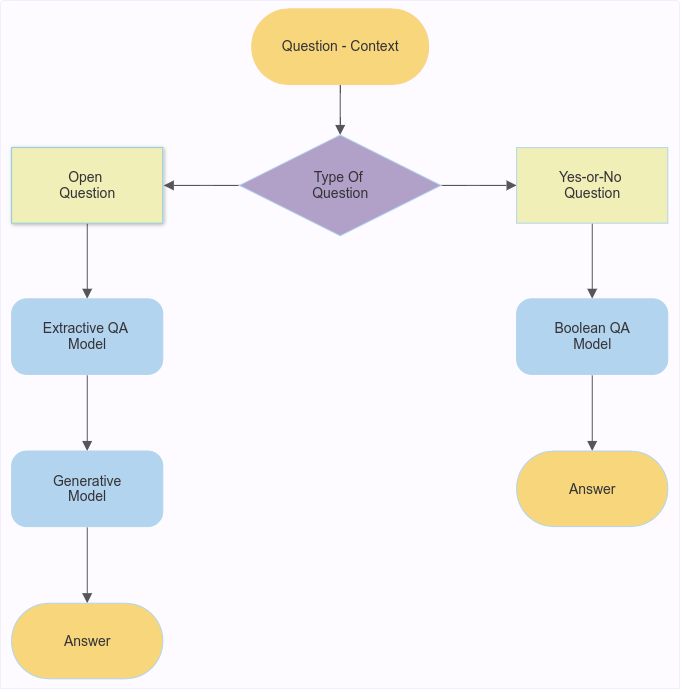
    

## Yes-or-No QA Classification

In order to correctly pass the question to the correct branch of our ensamble, we first need a model that can divide open question from yes-or-no ones.

### Preprocessing and dataset manipulation

In [ ]:
# Copy the original dataframe
df_train_qa_classification = df_train_qa.copy()

# Drop usless columns for classification
df_train_qa_classification = df_train_qa_classification.drop(['story_id', 'story', 'R1_start', 'R1_end', 'R1', 'answer'], axis=1)

# Convert columns to lowercase
df_train_qa_classification['question'] = df_train_qa_classification['question'].apply(str.lower)

df_train_qa_classification

,question,y
0,when was the vat formally opened?,0
1,what is the library for?,0
2,for what subjects?,0
3,and?,0
4,what was started in 2014?,0
...,...,...
108642,who was a sub?,0
108643,was it his first game this year?,1
108644,what position did the team reach?,0
108645,who was ahead of them?,0


In [ ]:
# Copy the original test dataframe
df_test_qa_classification = df_test_qa.copy()

We remember from our initial data analysis that yes-or-no question are quite less in number respect to open question, so we need to address this problem.

In this notebook we decided to perform **upsampling**. 

New total number of questions: 	 155265 

New number of yes/no questions:  68902 

New number of open questions: 	 86363 



<AxesSubplot:ylabel='Type'>

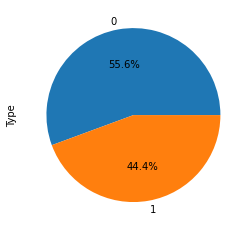

In [ ]:
# Get all the yes/no questions
yesno_questions = df_train_qa_classification[df_train_qa_classification["y"] == 1]
open_questions = df_train_qa_classification[df_train_qa_classification["y"] == 0]

# Perform upsampling on the yes/no question
yesno_questions_upsample = resample(yesno_questions,
             replace=True,
             n_samples=int(num_open/1.8),
             random_state=42)

# yesno_questions_downsample = resample(open_questions,
#              replace=True,
#              n_samples=int(num_open/1.5),
#              random_state=42)

# Merge and create the new upsampled dataframe
df_train_qa_classification_upsample = pd.concat([df_train_qa_classification,yesno_questions_upsample])

print("New total number of questions: \t", df_train_qa_classification_upsample.shape[0], "\n")
print("New number of yes/no questions: ", df_train_qa_classification_upsample[df_train_qa_classification_upsample['y'] == 1].shape[0], "\n")
print("New number of open questions: \t", df_train_qa_classification_upsample[df_train_qa_classification_upsample['y'] == 0].shape[0], "\n")


df_train_qa_classification_upsample.groupby('y').size().plot(kind='pie',
                                       y = "y",
                                       label = "Type",
                                       autopct='%1.1f%%')

### GridSearch to find best configuration

The [find the best model](https://towardsdatascience.com/multi-class-text-classification-model-comparison-and-selection-5eb066197568#:~:text=Linear%20Support%20Vector%20Machine%20is,the%20best%20text%20classification%20algorithms.) we opted between:

1. Naive bayes classifier
     
    Has the strong assumption of conditional indipendence between features, but we have some questions that are correlated.

    1. **Complement Naive Bayes**

        Particularly suited for imbalanced data sets

        CNB regularly outperforms MNB (often by a considerable margin) on text classification tasks	

    2. **Multinomial Naive Bayes**

        Variants used in text classification (where the data are typically represented as word vector counts, although tf-idf vectors are also known to work well in practice). 

2. **Linear Support Vector Machine**

  Linear Support Vector Machine is widely regarded as one of the best text classification algorithms

At the end **Linear SVM** was chosen.

In [ ]:
X = df_train_qa_classification_upsample['question']
y = df_train_qa_classification_upsample['y']

svm = Pipeline([
    ("pre", TfidfVectorizer()),
    ("svm", SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=5, tol=None))
])

parameters = {
    'pre__ngram_range': [(1, 1), (1, 2), (2,2)],
    'svm__max_iter': [5, 7],
    'svm__alpha': (1e-4, 1e-5)}

gs_svm = GridSearchCV(svm, parameters, cv=5, n_jobs=-1)

# svm = Pipeline([
#     ("pre", TfidfVectorizer(ngram_range= (1, 2))),
#     ("svm", SGDClassifier(loss='hinge', penalty='l2', alpha=1e-5, random_state=42, max_iter=7, tol=None))
# ])

gs_svm.fit(X,y)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pre', TfidfVectorizer()),
                                       ('svm',
                                        SGDClassifier(alpha=0.001, max_iter=5,
                                                      random_state=42,
                                                      tol=None))]),
             n_jobs=-1,
             param_grid={'pre__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'svm__alpha': (0.0001, 1e-05),
                         'svm__max_iter': [5, 7]})

In [ ]:
print("Best score reached: ",gs_svm.best_score_, "\n")

for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_svm.best_params_[param_name]))

Best score reached:  0.9795832930795736 

pre__ngram_range: (1, 2)
svm__alpha: 1e-05
svm__max_iter: 7


### Evluate performance

The svm accuracy is 0.9705733771154332 



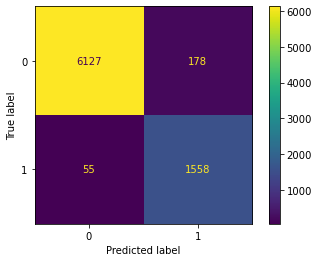


               precision    recall  f1-score   support

        open       0.99      0.97      0.98      6305
      yes_no       0.90      0.97      0.93      1613

    accuracy                           0.97      7918
   macro avg       0.94      0.97      0.96      7918
weighted avg       0.97      0.97      0.97      7918



In [ ]:
# Predict the categories of the test data
svm_pred = gs_svm.predict(df_test_qa_classification['question'])

print("The svm accuracy is {}".format(accuracy_score(df_test_qa_classification['y'], svm_pred)), "\n")

cm = confusion_matrix(df_test_qa_classification['y'], svm_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

print("\n", metrics.classification_report(df_test_qa_classification['y'], svm_pred, target_names=['open','yes_no']))

## Extractive QA Model

As before, due to computational limits, we take a subset of our training dataframe.

We also remove all the yes-or-no question as stated before.

In [ ]:
# Take a reduced portion of the dataframed to reuce computational costs
df_reduced_span = df_train_qa[df_train_qa['story_id'] <= 2300].copy()

# Remove yes/no questions
df_reduced_spa = df_reduced_span.drop(df_reduced_span[df_reduced_span['y'] == 1].index)

# Remove y column
df_reduced_span = df_reduced_span.drop(['y'], axis=1)

# Perform the split
df_train_span, df_val_span = train_val_split(df_reduced_span, 0.8, True)

In [ ]:
# Glance at the dataframe
df_train_span

,story_id,story,question,R1_start,R1_end,R1,answer
0,1,New York (CNN) -- More than 80 Michael Jackson...,Where was the Auction held?,243,284,Hard Rock Cafe in New York's Times Square,Hard Rock Cafe
1,1,New York (CNN) -- More than 80 Michael Jackson...,How much did they make?,180,210,reaping a total $2 million. \n,$2 million.
2,1,New York (CNN) -- More than 80 Michael Jackson...,How much did they expected?,292,342,"pre-sale expectations of only $120,000 in sal...","$120,000"
3,1,New York (CNN) -- More than 80 Michael Jackson...,WHo buy the Jackson Glove,1295,1365,"Hoffman Ma, who bought the glove on behalf of ...",Hoffman Ma
4,1,New York (CNN) -- More than 80 Michael Jackson...,Where was the buyer of the glove from?,1331,1366,"behalf of Ponte 16 Resort in Macau,",Macau
...,...,...,...,...,...,...,...
27260,2299,(CNN) -- The suspect in the killing of Yale ph...,What does he maintain at his job?,1189,1238,maintaining colonies for animals used in research,maintaining colonies for animals used in resea...
27261,2299,(CNN) -- The suspect in the killing of Yale ph...,When is the memorial for the victim?,1440,1477,memorial service for Le on October 12,"memorial service for Le on October 12, oct 12th"
27262,2299,(CNN) -- The suspect in the killing of Yale ph...,What else is the school doing to honor her?,1479,1543,The university is also establishing a scholars...,The university is also establishing a scholars...
27263,2299,(CNN) -- The suspect in the killing of Yale ph...,What city is the defendant from?,644,675,"Clark, of Branford, Connecticut","Clark, of Branford, Connecticut , connecticut"


In [ ]:
# Convert to hg dataset
hg_ds_span = convert_to_hg_dataset(['story_id', 'R1', 'answer'], df_train_span, df_val_span)
hg_ds_span

DatasetDict({
    train: Dataset({
        features: ['story', 'question', 'R1_start', 'R1_end'],
        num_rows: 27265
    })
    val: Dataset({
        features: ['story', 'question', 'R1_start', 'R1_end'],
        num_rows: 6792
    })
})

In this case, the `ALBERT` model was chosen, but it can be exchanged to any other model if wanted.

For example, we also briefly tried also a lighter model such as `distillroberta` but it did not perform as good as `ALBERT`.

In [ ]:
model_checkpoint_span = "squirro/albert-base-v2-squad_v2"

In [ ]:
# Import pretrained tokenizer and model for extractive QA
tokenizer_span = AutoTokenizer.from_pretrained(model_checkpoint_span)
model_span = TFAutoModelForQuestionAnswering.from_pretrained(model_checkpoint_span)

All model checkpoint layers were used when initializing TFAlbertForQuestionAnswering.

All the layers of TFAlbertForQuestionAnswering were initialized from the model checkpoint at squirro/albert-base-v2-squad_v2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFAlbertForQuestionAnswering for predictions without further training.


### Preprocessing

Now, the most important part in Extractive QA is to correctly find the span, so correctly tokenize each input is essential.

Usually, it is accettable to truncate long input sequence if they are longer than the maximum input length, but here, removing part of the the context might result in losing span where the answer lies.

To deal with this, we allow long input sequence to be truncated and given as several input sequence.

Also, in case the answer lies at the point we split the context, we allow some overlap between the features we generate controlled by the hyper-parameter `doc_stride`.


In [ ]:
# The maximum length of a feature (question and context)
max_length = 384 

# The overlap between two part of the context when splitting is performed.
doc_stride = 128  

To correctly perofmed the tokenization, we implemented [this](https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/question_answering-tf.ipynb#scrollTo=t0Fu_vte8XGz) tokenization function provided in a HuggingFace notebook,

Essentialy:
- We allow our tokenize to truncate our input sequence, but we assure it truncates only the story and not the question by providing the `truncation="only_second"` method.
- Next, we have to tell the tokenizer to keep the list of truncated featured by specifying `return_overflowing_tokens=True` and passing the `stride` we want to keep when keeping the overflowing part of the input sequence.
- Now we could have several lists of`input_ids` per input, so the problem now is to correctly find again the span of text where the answer lies. To perform this task we need to know the position of each feature, and this is done by specifying `return_offsets_mapping=True`. We will obtain the corresponding start and end character in the original text for each token in our input IDs.

In [ ]:
idx = 210

tokenized_example = tokenizer_span(
    hg_ds_span['train']["question"][idx],
    hg_ds_span['train']["story"][idx],
    max_length=max_length,
    truncation="only_second",
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
    stride=doc_stride,
)

print("Example of tokenization:\n")
for x in tokenized_example["input_ids"]:
    print(tokenizer_span.decode(x))
    
print("\n\nExample of offset mapping:")
print("\n", tokenized_example["offset_mapping"])

Example of tokenization:

[CLS] what is one of their hashtags?[SEP] a chinese actor's divorce from his wife, over her alleged extramarital affair, has social media buzzing, with posts about the subject gaining over five billion views. wang baoqiang announced online on sunday that he was divorcing his wife, ma rong, and sacking his agent, song zhe. he alleged that his marriage broke down after his wife had an affair with his agent, and that she had also transferred the couple's joint assets. ma has hit back at wang, accusing him of abandoning their family. the topic has sparked a debate about relationships and divorce. it seems wang's situation has struck a chord with many - which could explain the number of views, which are high even by chinese standards. the divorce quickly became a top trending topic in china. according to micro blog sina weibo, posts with the hashtag "wang baoqiang divorce" have been viewed over five billion times. chinese netizens seem to have rallied around wang, 

- We need to distinguish the question and context part of the input, and this is performed using the `sequence_ids()` method, which will return a sequence of form `[None, 0, 0, 0, None, 1, 1, 1, 1, 1, 1, None]` where: `None` are for special tokens, `0` for tokens corresponding to words in the first sequence and `1` for tokens corresponding to words in the second sequence.

In [ ]:
sequence_ids = tokenized_example.sequence_ids()
print(sequence_ids)

[None, 0, 0, 0, 0, 0, 0, 0, 0, 0, None, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

- Now with everything, we can find the first and last token of the answer in one of our input feature (or if the answer is not in this feature)

In [ ]:
start_char = hg_ds_span['train']["R1_start"][idx]
end_char = hg_ds_span['train']["R1_end"][idx]

print("Original start: ", start_char)
print("Original end: ", end_char)

# Start token index of the current span in the text.
token_start_index = 0
while sequence_ids[token_start_index] != 1:
    token_start_index += 1
    
print("\nStart token index of the current span: ", token_start_index)

# End token index of the current span in the text.
token_end_index = len(tokenized_example["input_ids"][0]) - 1
while sequence_ids[token_end_index] != 1:
    token_end_index -= 1
    
print("End token index of the current span: ", token_end_index, "\n")

# Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
offsets = tokenized_example["offset_mapping"][0]
print("Start token index of whole mapping: ", offsets[token_start_index][0])
print("End token index of whole mapping: ", offsets[token_end_index][1])
if (
    offsets[token_start_index][0] <= start_char
    and offsets[token_end_index][1] >= end_char
):
    # Move the token_start_index and token_end_index to the two ends of the answer.
    while (
        token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char
    ):
        token_start_index += 1
    start_position = token_start_index - 1
    while offsets[token_end_index][1] >= end_char:
        token_end_index -= 1
    end_position = token_end_index + 1
    print("\nNew start-end positions: ", start_position, end_position)
else:
    print("The answer is not in this feature.")

Original start:  822
Original end:  843

Start token index of the current span:  11
End token index of the current span:  382 

Start token index of whole mapping:  0
End token index of whole mapping:  1631

New start-end positions:  191 196


In [ ]:
print("Re-aligned start-end tokens:\n",
    tokenizer_span.decode(
        tokenized_example["input_ids"][0][start_position : end_position + 1]
    )
)
print("\nOriginal answer span:\n",hg_ds_span['train']["story"][idx][hg_ds_span['train']["R1_start"][idx] : hg_ds_span['train']["R1_end"][idx]])

Re-aligned start-end tokens:
 wang baoqiang divorce

Original answer span:
 Wang BaoQiang Divorce


Finally, we can combine everything explained before and create a preprocess function which will correctly preprocess batches of our inputs.

In [ ]:
def preprocess_function_span(examples):
    # Tokenize our examples with truncation and padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer_span(
        examples["question"],
        examples["story"],
        truncation="only_second",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
    # The offset mappings will give us a map from token to character position in the original context. This will
    # help us compute the start_positions and end_positions.
    offset_mapping = tokenized_examples.pop("offset_mapping")

    # Let's label those examples!
    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []


    for i, offsets in enumerate(offset_mapping):
        # We will label impossible answers with the index of the CLS token.
        input_ids = tokenized_examples["input_ids"][i]
        cls_index = input_ids.index(tokenizer_span.cls_token_id)

        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]

        # If no answers are given, set the cls_index as answer.
        if  examples['R1_start'] == 0:
            tokenized_examples["start_positions"].append(cls_index)
            tokenized_examples["end_positions"].append(cls_index)
        else:
            # Start/end character index of the answer in the text.
            start_char = examples['R1_start'][sample_index]
            end_char = examples['R1_end'][sample_index]

            # Start token index of the current span in the text.
            token_start_index = 0
            while sequence_ids[token_start_index] != 1:
                token_start_index += 1

            # End token index of the current span in the text.
            token_end_index = len(input_ids) - 1
            while sequence_ids[token_end_index] != 1:
                token_end_index -= 1

            # Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
            if not (
                offsets[token_start_index][0] <= start_char
                and offsets[token_end_index][1] >= end_char
            ):
                tokenized_examples["start_positions"].append(cls_index)
                tokenized_examples["end_positions"].append(cls_index)
            else:
                # Otherwise move the token_start_index and token_end_index to the two ends of the answer.
                # Note: we could go after the last offset if the answer is the last word (edge case).
                while (
                    token_start_index < len(offsets)
                    and offsets[token_start_index][0] <= start_char
                ):
                    token_start_index += 1
                tokenized_examples["start_positions"].append(token_start_index - 1)
                while offsets[token_end_index][1] >= end_char:
                    token_end_index -= 1
                tokenized_examples["end_positions"].append(token_end_index + 1)

    return tokenized_examples

In [ ]:
# Preprocess our train and val datasets
tokenized_datasets_span = hg_ds_span.map(
    preprocess_function_span, batched=True, remove_columns=hg_ds_span["train"].column_names
)

  0%|          | 0/28 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

In [ ]:
tokenized_datasets_span

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 28189
    })
    val: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 7124
    })
})

### Fine-tuning the model

In [ ]:
# Training hyperparameters

learning_rate = 5e-5 #[2,5]e-5
num_train_epochs = 1
weight_decay = 0.001
batch_size = 16

# Optimizer
optimizer = AdamWeightDecay(learning_rate=learning_rate,
                            weight_decay_rate=weight_decay,)

We now convert our dataset to `tf.data.Dataset` as we arleady done before, and this time we will use the default `DataCollator` since our input sequence are already padded to the same length and ready to be dealt with.

In [ ]:
train_set_span = model_span.prepare_tf_dataset(
    tokenized_datasets_span["train"],
    shuffle=True,
    batch_size=batch_size
)

validation_set_span = model_span.prepare_tf_dataset(
    tokenized_datasets_span["val"],
    shuffle=False,
    batch_size=batch_size
)

In [ ]:
# Compile the model
model_span.compile(optimizer=optimizer)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


In [ ]:
model_span.fit(
    train_set_span,
    validation_data=validation_set_span,
    epochs=num_train_epochs
)

1761/1761 [==============================] - 3546s 2s/step - loss: 2.8990 - val_loss: 2.8192


### Inference

In [ ]:
idx = 220

# inputs = tokenizer([question], [context], return_tensors="np")
inputs = tokenizer_span([df_val_span['question'][idx]], [df_val_span['story'][idx]], return_tensors="np")

outputs = model_span(inputs)

start_position = np.argmax(outputs.start_logits[0])
end_position = np.argmax(outputs.end_logits[0])

# Extract this substring from the inputs
answer = inputs["input_ids"][0, start_position:end_position + 1]

print("\nQuestion: ", df_val_span['question'][idx], "\n\n")
print("Model answer:  \t",tokenizer_span.decode(answer))
print("\nR1: \t\t", df_val_span['R1'][idx])
print("\nReal answer: \t",df_val_span['answer'][idx])


Question:  When was the city formed? 


Model answer:  	 the city was incorporated in 1852

R1: 		 n 1852. 

Real answer: 	 In 1852


In [ ]:
n_samples = 2000
test_eval_subset = df_test_qa.sample(n = n_samples, random_state = seed).reset_index()
f1s = []
ems = []

for idx in tqdm(range(n_samples)):

    inputs = tokenizer_span([test_eval_subset['question'][idx]], [test_eval_subset['story'][idx]], return_tensors="np", truncation="only_second", max_length=max_length,)

    outputs = model_span(inputs)

    ref_text = test_eval_subset['R1'][idx]
    ref_start = test_eval_subset['R1_start'][idx]

    start_position = np.argmax(outputs.start_logits[0])
    end_position = np.argmax(outputs.end_logits[0])

    # Extract this substring from the inputs
    answer = inputs["input_ids"][0, start_position:end_position + 1]
    answer = tokenizer_span.decode(answer)

    predictions = [{'prediction_text': answer, 'id': '1'}]
    references = [{'answers': {'answer_start': [ref_start], 'text': [ref_text]}, 'id': '1'}]
    results = squad_metric.compute(predictions=predictions, references=references)
    f1s.append(results['f1'])
    ems.append(results['exact_match'])

print("\n\nmean F1: ", np.mean(f1s))
print("\n\nmean EM: ", np.mean(ems))

100%|██████████| 2000/2000 [04:19<00:00,  7.70it/s]



mean F1:  49.82883214941282


mean EM:  21.6


## Answer Generator Model

A brief summary of our ensamble up to this point:
- Machine Learning model to filter yes-or-no question from open question
- Model for ExtractiveQA to find the span of the answer of open question

And now, we just need to "re-arrange" the span of the answer to generate the final correct answer.

More precisely, our objective is in between paraphrasing and summarizing the extracted span to generate the answer.

The nature of this problem is the same as our first Generative QA approach, so we decided to utilize the same T5 architecture.

In [ ]:
# Copy the original train set, if needed, it can be reduced
df_gqa = df_train_qa.copy()

# Remove yes/no questions
df_gqa = df_gqa.drop(df_gqa[df_gqa['y'] == 1].index)

# Remove y column
df_gqa = df_gqa.drop(['y'], axis=1)

# Perform the split
df_train_gqa, df_val_gqa = train_val_split(df_gqa, 0.8, True)

In [ ]:
hg_ds_gqa = convert_to_hg_dataset(['story_id', 'story', 'R1_start', 'R1_end'], df_train_gqa, df_val_gqa)

In [ ]:
model_checkpoint_gqa = "t5-small"
tokenizer_gqa = AutoTokenizer.from_pretrained(model_checkpoint_gqa)
model_gqa = TFT5ForConditionalGeneration.from_pretrained(model_checkpoint_gqa)

/opt/conda/lib/python3.7/site-packages/transformers/models/t5/tokenization_t5_fast.py:165: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  FutureWarning,
All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at t5-small.
If your task is similar to the task the model of the 

### Preprocessing

In [ ]:
max_input_length = 512
max_target_length = 128


def preprocess_function_gqa(examples):
    inputs = 'question: %s  context: %s' % (examples['question'], examples['R1'])
    model_inputs = tokenizer_gqa(inputs, max_length=max_input_length, truncation=True)

    # Setup the tokenizer for targets
    with tokenizer_gqa.as_target_tokenizer():
        labels = tokenizer_gqa(
            examples["answer"], max_length=max_target_length, truncation=True
        )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:
tokenized_datasets_gqa = hg_ds_gqa.map(preprocess_function_gqa, remove_columns=hg_ds_gqa["train"].column_names)

  0%|          | 0/69069 [00:00<?, ?ex/s]

/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:3582: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  "`as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your "


  0%|          | 0/17294 [00:00<?, ?ex/s]

In [ ]:
tokenized_datasets_gqa

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 69069
    })
    val: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 17294
    })
})

In [ ]:
idx = 42
print(tokenizer_gqa.decode(tokenized_datasets_gqa["train"]['input_ids'][idx]))
print("\n\n",tokenizer_gqa.decode(tokenized_datasets_gqa["train"]['labels'][idx]))

print("\n\n",tokenized_datasets_gqa["train"]['input_ids'][idx])
print("\n\n",tokenized_datasets_gqa["train"]['labels'][idx])

question: What Island does he travel to? context: After ending up on the Island of Misfit Toys</s>


 the Island of Misfit Toys</s>


 [822, 10, 363, 2834, 405, 3, 88, 1111, 12, 58, 2625, 10, 621, 7784, 95, 30, 8, 2834, 13, 8306, 5616, 304, 63, 7, 1]


 [8, 2834, 13, 8306, 5616, 304, 63, 7, 1]


### Fine-tuning the model

In [ ]:
# Hyperparams
learning_rate = 2e-4 #1e-4
num_train_epochs = 1
weight_decay = 0.01
batch_size = 8

optimizer = AdamWeightDecay(learning_rate=learning_rate,
                            weight_decay_rate=weight_decay,)

data_collator = DataCollatorForSeq2Seq(tokenizer_gqa, model=model_gqa, return_tensors="np")

In [ ]:
train_set_gqa = model_gqa.prepare_tf_dataset(
    tokenized_datasets_gqa["train"],
    batch_size=batch_size,
    shuffle=True,
    collate_fn=data_collator,
)

val_set_gqa = model_gqa.prepare_tf_dataset(
    tokenized_datasets_gqa["val"],
    batch_size=batch_size,
    shuffle=False,
    collate_fn=data_collator,
)

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [ ]:
# Compile the model
model_gqa.compile(optimizer=optimizer)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


In [ ]:
# Train the model
model_gqa.fit(
    x=train_set_gqa,
    validation_data=val_set_gqa,
    epochs=num_train_epochs
)

8633/8633 [==============================] - 940s 107ms/step - loss: 0.7886 - val_loss: 0.6905


### Inference

In [ ]:
idx = 42

input_text =  f"question: {df_val_gqa['question'][idx]} context: {df_val_gqa['R1'][idx]}"

input_tokenized = tokenizer_gqa(input_text, return_tensors='np', pad_to_max_length=True, truncation=True, max_length=512)

input_ids = input_tokenized.input_ids
attention_mask = input_tokenized.attention_mask

model_answer = model_gqa.generate(input_ids)#, num_beams=4, length_penalty= 1.5, no_repeat_ngram_size=2)

print("\nQuestion: ", df_val_gqa['question'][idx], "\n\n")
print("R1: \t\t", df_val_gqa['R1'][idx])
print("\n\nModel answer:  \t",tokenizer_gqa.decode(model_answer[0], skip_special_tokens=True))
print("\nReal answer: \t",df_val_gqa['answer'][idx])

/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2345: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/transformers/generation/tf_utils.py:707: UserWarning: Neither `max_length` nor `max_new_tokens` have been set, `max_length` will default to 20 (`generation_config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  UserWarning,



Question:  How many wolves were initially following him? 


R1: 		 It was a long way from my friend's house when about twenty wolves began to follow my sleigh


Model answer:  	 twenty

Real answer: 	 About twenty


In [ ]:
n_samples = 2000
test_eval_subset = df_test_qa.sample(n = n_samples, random_state = seed).reset_index()
f1s = []
ems = []

for idx in tqdm(range(n_samples)):
      
    input_text =  f"question: {test_eval_subset['question'][idx]} context: {test_eval_subset['R1'][idx]}"
    inputs = tokenizer_gqa(input_text, return_tensors='np', pad_to_max_length=True, truncation=True, max_length=512)
    input_ids = inputs.input_ids

    outputs = model_gqa.generate(input_ids)

    ref_text = test_eval_subset['answer'][idx]
    ref_start = test_eval_subset['R1_start'][idx]

    # Decode the answer
    answer = tokenizer_gqa.decode(outputs[0], skip_special_tokens=True)
    
    predictions = [{'prediction_text': answer, 'id': '1'}]
    references = [{'answers': {'answer_start': [ref_start], 'text': [ref_text]}, 'id': '1'}]
    results = squad_metric.compute(predictions=predictions, references=references)
    f1s.append(results['f1'])
    ems.append(results['exact_match'])

print("\n\nmean F1: ", np.mean(f1s))
print("\n\nmean EM: ", np.mean(ems))

100%|██████████| 2000/2000 [17:32<00:00,  1.90it/s]



mean F1:  64.88787973514931


mean EM:  51.9


## Boolean QA

First, we need to adjust our dataset, in our case we just need the yes-or-no questions and a new column, that we called `yes-no` which represent the answer in boolean format.

The same dataframe manipulation is also applied to the test dataset.

In [ ]:
# Take a copy of the train set with only yes-or-no questions
df_train_qa_yn = df_train_qa[df_train_qa['y'] == 1].copy()

# Lower the answer to better process 
df_train_qa_yn['answer'] = df_train_qa_yn['answer'].apply(str.lower)

# Set as 1 yes and 0 no answers
df_train_qa_yn['yes-no'] = df_train_qa_yn.apply(lambda x: 1 if(x['answer'] == 'yes' or x['answer'] == 'yes.') else 0, axis=1)

# Drop the now useless y column
df_train_qa_yn = df_train_qa_yn.drop(['y'], axis = 1)

# Reset the index
df_train_qa_yn = df_train_qa_yn.reset_index(drop=True)

df_train_qa_yn

,story_id,story,question,R1_start,R1_end,R1,answer,yes-no
0,2,"CHAPTER VII. THE DAUGHTER OF WITHERSTEEN \n\n""...",Did he agree?,99,129,"""I reckon so,"" he had replied.",yes,1
1,2,"CHAPTER VII. THE DAUGHTER OF WITHERSTEEN \n\n""...",Did she tell him as much?,307,360,though she could not have spoken aloud all she...,no,0
2,2,"CHAPTER VII. THE DAUGHTER OF WITHERSTEEN \n\n""...",Did she allow herself to even think it?,640,666,she did not even think it.,no,0
3,2,"CHAPTER VII. THE DAUGHTER OF WITHERSTEEN \n\n""...",Did Jane think she could control Lassiter?,1141,1205,"If she could not wholly control Lassiter, then...",no,0
4,2,"CHAPTER VII. THE DAUGHTER OF WITHERSTEEN \n\n""...",Was Lassiter impressed with the horse?,1360,1450,"When Jerd led out this slender, beautifully bu...",yes,1
...,...,...,...,...,...,...,...,...
20918,7197,"Frankfurt, officially Frankfurt am Main (Liter...",Does the city have tech startups?,1279,1313,several cloud and fintech startups,yes,1
20919,7197,"Frankfurt, officially Frankfurt am Main (Liter...",Is it large?,1522,1580,Messe Frankfurt is one of the world's largest ...,yes,1
20920,7197,"Frankfurt, officially Frankfurt am Main (Liter...",Is there a music fair?,1659,1673,the Music Fair,yes,1
20921,7198,(CNN) -- Cristiano Ronaldo provided the perfec...,Was Bale 25 years old?,1235,1259,faith in the 24-year-old,no,0


In [ ]:
df_train_yn, df_val_yn = train_val_split(df_train_qa_yn, 0.8, True)

In [ ]:
# Take a copy of the test set with only yes-or-no questions
df_test_yn = df_test_qa[df_test_qa['y'] == 1].copy()

# Lower the answer to better process 
df_test_yn['answer'] = df_test_yn['answer'].apply(str.lower)

# Set as 1 yes and 0 no answers
df_test_yn['yes-no'] = df_test_yn.apply(lambda x: 1 if(x['answer'] == 'yes' or x['answer'] == 'yes.') else 0, axis=1)

# Drop the now useless y column
df_test_yn = df_test_yn.drop(['y'], axis = 1)

# Reset the index
df_test_yn = df_test_yn.reset_index(drop=True)

df_test_yn

,story_id,story,question,R1_start,R1_end,R1,answer,yes-no
0,0,"Once upon a time, in a barn near a farm house,...",Did she live alone?,196,215,Cotton wasn't alone,no,0
1,0,"Once upon a time, in a barn near a farm house,...",Was Cotton happy that she looked different tha...,512,549,Being different made Cotton quite sad,no,0
2,0,"Once upon a time, in a barn near a farm house,...",Did they want Cotton to change the color of he...,965,1008,We would never want you to be any other way,no,0
3,1,Once there was a beautiful fish named Asta. As...,Was Sharkie a friend?,281,302,Asta's friend Sharkie,yes,1
4,1,Once there was a beautiful fish named Asta. As...,did they get the bottle?,552,577,So they caught the bottle,yes,1
...,...,...,...,...,...,...,...,...
1608,499,"Las Vegas (, Spanish for ""The Meadows""), offic...",Is it a popular spot for business meetings?,750,826,It is a top three destination in the United S...,yes,1
1609,499,"Las Vegas (, Spanish for ""The Meadows""), offic...",Does it have many Five Diamond hotels?,876,946,claiming more AAA Five Diamond hotels than any...,yes,1
1610,499,"Las Vegas (, Spanish for ""The Meadows""), offic...",Is it a popular tourist desination?,955,1036,Las Vegas annually ranks as one of the world's...,yes,1
1611,499,"Las Vegas (, Spanish for ""The Meadows""), offic...",Is it located in a desert?,326,358,within the greater Mojave Desert,yes,1


As previously stated, this problem can be dealt as a classification one, so it was utilized the `SequenceClassification` class.

In our case the lable to assign are:

- 0 = No
- 1 = Yes


For this part the [`distilroberta-base`](https://huggingface.co/distilroberta-base) model was chosen.

As before, the right choice of model is up to debate, in this notebook `distilroberta-base` was chosen since the boolean QA was believed to be the easiest part of the ensamble and, in order to avoid excessive complexity, the distilled version of RoBERTa was a suitable candidate.

In [ ]:
model_checkpoint_yn = "distilroberta-base"
tokenizer_yn = AutoTokenizer.from_pretrained(model_checkpoint_yn)
model_yn = TFAutoModelForSequenceClassification.from_pretrained(model_checkpoint_yn)

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Preprocessing

In [ ]:
hg_ds_yn = convert_to_hg_dataset(['story_id', 'R1', 'R1_start', 'R1_end', 'answer'], df_train_yn, df_val_yn)

In [ ]:
hg_ds_yn

DatasetDict({
    train: Dataset({
        features: ['story', 'question', 'yes-no'],
        num_rows: 16699
    })
    val: Dataset({
        features: ['story', 'question', 'yes-no'],
        num_rows: 4224
    })
})

In [ ]:
def preprocess_function_yn(examples):
    # Correctly format the inputs
    model_inputs = tokenizer_yn(examples['question'], examples['story'], truncation="only_second")

    model_inputs["labels"] = examples["yes-no"]
    return model_inputs

In [ ]:
tokenized_datasets_yn = hg_ds_yn.map(preprocess_function_yn, remove_columns=hg_ds_yn["train"].column_names, batched=True)

  0%|          | 0/17 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

### Fine-tuning the model

In [ ]:
# Training hyperparameters

learning_rate = 2e-5 #1e-4
num_train_epochs = 1
weight_decay = 0.01
batch_size = 8

optimizer = AdamWeightDecay(learning_rate = learning_rate,
                            weight_decay_rate = weight_decay,)

In [ ]:
train_set_yn = model_yn.prepare_tf_dataset(
    tokenized_datasets_yn["train"],
    batch_size=batch_size,
    shuffle=True,
    tokenizer=tokenizer_yn
)

val_set_yn = model_yn.prepare_tf_dataset(
    tokenized_datasets_yn["val"],
    batch_size=batch_size,
    shuffle=False,
    tokenizer=tokenizer_yn
)

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [ ]:
# Compile the model
model_yn.compile(optimizer=optimizer)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


In [ ]:
# Train the model
model_yn.fit(
    x=train_set_yn,
    validation_data=val_set_yn,
    epochs=num_train_epochs
)

2087/2087 [==============================] - 1064s 506ms/step - loss: 0.6532 - val_loss: 0.5269


### Inference

In [ ]:
idx = 123

tokenized = tokenizer_yn(df_val_yn['question'][idx], df_val_yn['story'][idx], return_tensors="np", truncation="only_second")

outputs = model_yn(tokenized).logits

classifications = np.argmax(outputs, axis=1)
print("Question:\n", df_val_yn['question'][idx])
print("\nReal answer:\n", df_val_yn['answer'][idx])
print("\nModel answer:\n",classifications)
print(outputs)

Question:
 Is his mom Mrs. Massanet?

Real answer:
 no

Model answer:
 [0]
tf.Tensor([[ 0.4900276 -0.5386593]], shape=(1, 2), dtype=float32)


In [ ]:
accuracy_score = load('accuracy')

predictions = []
true = []

for idx in tqdm(range(df_test_yn.shape[0])):
    inputs = tokenizer_yn(df_test_yn['question'][idx], df_test_yn['story'][idx], return_tensors="np", truncation="only_second")
    
    outputs = model_yn(inputs).logits
    classification = np.argmax(outputs, axis=1)
    
    predictions.append(classification[0])
    true.append(df_test_yn['yes-no'][idx])
    
accuracy_score.compute(predictions=predictions, references=true)


100%|██████████| 1613/1613 [01:49<00:00, 14.73it/s]


{'accuracy': 0.7067575945443273}

## Create the ensamble

In [ ]:
def ensamble_model(context, question):
    
    max_length = 1024
    
    predicted_type = gs_svm.predict([question])
    
    # yes-or-no
    if predicted_type == 1:
        # Format the input
        inputs_yn = tokenizer_yn(question, context, return_tensors="np", truncation="only_second")
        # Get the output
        outputs = model_yn(inputs_yn).logits
        result = np.argmax(outputs, axis=1)
        
        if result == 1:
            return "Yes"
        elif result == 0:
            return "No" 
    
    # Open question
    elif predicted_type == 0:
        # Format the input
        inputs_span = tokenizer_span([question], [context], return_tensors="np", truncation="only_second", max_length=max_length,)
        # Get the output
        outputs = model_span(inputs_span)
        start_position = np.argmax(outputs.start_logits[0])
        end_position = np.argmax(outputs.end_logits[0])
        # Extract this substring from the inputs
        extracted_span = inputs_span["input_ids"][0, start_position:end_position + 1]
        # Decode the answer
        extracted_span = tokenizer_span.decode(extracted_span)
        
        # Process the input
        input_text =  f"question: {question} context: {extracted_span}"
        inputs = tokenizer_gqa(input_text, return_tensors='np', pad_to_max_length=True, truncation=True, max_length=512)
        input_ids = inputs.input_ids
        # Generate the answer
        outputs = model_gqa.generate(input_ids)
        # Decode the answer
        answer = tokenizer_gqa.decode(outputs[0], skip_special_tokens=True)
        
        return answer


In [ ]:
test_eval_subset = df_test_qa.sample(n = n_samples, random_state = seed).reset_index()
idx = 123
idx2 = 722
    
print("Question: ", test_eval_subset['question'][idx])
print("\nReal Answer: ", test_eval_subset['answer'][idx])
print("\nModel Answer: ", ensamble_model(test_eval_subset['story'][idx], test_eval_subset['question'][idx]))

print("-"*40)

print("\nQuestion: ", test_eval_subset['question'][idx2])
print("\nReal Answer: ", test_eval_subset['answer'][idx2])
print("\nModel Answer: ", ensamble_model(test_eval_subset['story'][idx2], test_eval_subset['question'][idx2]))

print("-"*40)

print("\nContext: ", test_eval_subset['story'][700])
print("\nQuestion: ", test_eval_subset['question'][700])
print("\nReal Answer: ", test_eval_subset['answer'][700])
print("\nModel Answer: ", ensamble_model(test_eval_subset['story'][700], test_eval_subset['question'][700]))

Question:  is another movie he is in mentioned?

Real Answer:  YEs.

Model Answer:  Yes
----------------------------------------

Question:  What is it called in Hebrew?

Real Answer:  Milhemet Sheshet Ha Yamim

Model Answer:  milhemet sheshet ha yamim"
----------------------------------------

Context:  (CNN) -- Each year, Grammy Week offers up a full calendar of events -- each one boasting a guest list more spectacular than the next. But this year, the most coveted ticket was Friday night's "2013 MusiCares Person of the Year Tribute" honoring Bruce Springsteen. 

The evening's entertainment featured six Rock and Roll Hall of Famers, a few critically acclaimed young artists -- and The Boss himself. 

Neil Young and Crazy Horse turned up the volume with a spirited version of "Born in the U.S.A," flanked by a pair of cheerleaders with the letter "S" emblazoned on their sweaters. Colombian superstar Juanes put a bilingual spin on "Hungry Heart," singing verses in both Spanish and English

In [ ]:
squad_metric = load("squad")

n_samples = 1000
f1s = []
ems = []

for idx in tqdm(range(n_samples)):
      
    # Generate the answer
    answer = ensamble_model(test_eval_subset['story'][idx], test_eval_subset['question'][idx])

    ref_text = test_eval_subset['answer'][idx]
    ref_start = test_eval_subset['R1_start'][idx]
    
    predictions = [{'prediction_text': answer, 'id': '1'}]
    references = [{'answers': {'answer_start': [ref_start], 'text': [ref_text]}, 'id': '1'}]
    results = squad_metric.compute(predictions=predictions, references=references)
    f1s.append(results['f1'])
    ems.append(results['exact_match'])

print("\n\nmean F1: ", np.mean(f1s))
print("\n\nmean EM: ", np.mean(ems))

100%|██████████| 1000/1000 [09:00<00:00,  1.85it/s]



mean F1:  55.44076754686662


mean EM:  44.2


# Conclusions

## Results analysis

### T5

- mean F1:  54.72581772847185

- mean EM:  43.9

- Total Time = 2751s | 46m

### Ensamble

- mean F1:  55.44076754686662

- mean EM:  44.2

- Total Time = 4550s | 1h 15m

### Simple Encoder-Decoder

- mean F1:  0.14790483405483407

- Total Time = 2453s | 41m

## SoTA Comparison

The current [state of the art](https://paperswithcode.com/sota/generative-question-answering-on-coqa), unfortunately, does not have a large number of papers associated with the Generative QA task on CoQA.

Nonetheless, our ensamble approach is actually an improvement over the original CoQA paper, reaching our 55.4 F1 score over their 45.4.

The current SoTA paper reaches an F1 score of 84.5 using a fine crafted model, trained in addition on extra data, which can perform a variety of tasks such as summarization of dialog generation.

## Comments

At the end, performance were particularly similar, having the ensamble being effectively a bit more accurate.

However, this result does not prove that this ensamble could actually outperform the original T5 approach, since the two network had different training time.

We had to limit the subset of samples on the T5 approach due to the limitation of our environment but, nevertheless, it managed to achieve similar high performance with more samples and less training time with respect to the Extractive QA.

The most computational demanding part of the ensamble was the Extractive QA part, which required the most amount of training and inevitably was the main responsable for the ensamble performance.

A clear advantage was found with respect to the normal Encoder-Decoder approach used in the NLP assignment. At that time we were limited in using the `EncoderDecoder` module of huggingface initialized for sequence-to-sequence approach and the `distillroberta` model.
Due to the complexity of the problem, this latter approach did not provide any good result.

The ensamble approach, as was proven in many other deep learning fields, showed to be a huge improvement with respect to these simpler approaches.

## Future Development

Newer approaches such as T5 proved to be quite performing, clearly being the better alternative to our ensamble which, even if it performed quite well, the complexity and the training time required outweighted its accuracy.

However, the ensamble could still be quite improved by:
- Finding better hyperparameters
- Changing different models
- Provide the history of the questions-answers to the model
- Testing it performance on the SQuAD dataset
